In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50

In [ ]:
# Path to the dataset
data_path = '/kaggle/input/faces-cvpr/Faces/'

# List the categories (folders) in the data path
categories = [folder for folder in os.listdir(data_path) if folder != "img"]
print(categories)

['Abir', 'Tishad', 'Touhid', 'Shimla']


In [ ]:
#Prepare the training data
train_data = []

# Limit the number of images per class
max_images_per_class = 1000

for c in categories:
    path = os.path.join(data_path, c)
    class_index = categories.index(c)
    count = 0  # Counter for the current class

    for img in tqdm(os.listdir(path)):
        if count >= max_images_per_class:  # Stop after max_images_per_class images
            break

        try:
            # Read the image in grayscale
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            # Normalize and resize the image
            img_arr = img_arr / 255.0  # Normalize to range [0, 1]
            img_arr = cv2.resize(img_arr, (256, 256))
            # Convert grayscale to RGB by stacking
            img_arr_rgb = np.stack((img_arr, img_arr, img_arr), axis=-1)
            # Append the image and its class label to the training data
            train_data.append([img_arr_rgb, class_index])
            count += 1  # Increment the counter
        except Exception as e:
            print(f"Error processing image {img}: {e}")

print(f"Total training samples: {len(train_data)}")


 33%|███▎      | 1000/3030 [00:09<00:18, 108.53it/s]

Total training samples: 4000


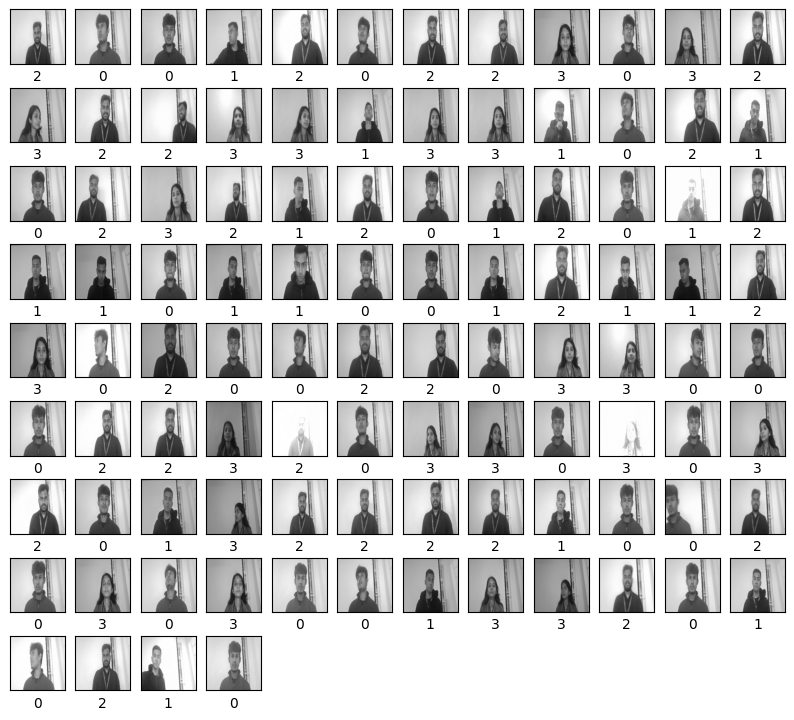

In [ ]:
# Plot a subset of images
np.random.shuffle(train_data)
plt.figure(figsize=(10,10))
i = 0
for r in range(10):
    for c in range(10):
        plt.subplot(10, 12, i + 1)
        plt.imshow(train_data[i][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(train_data[i][1])
        i += 1
plt.show()

In [ ]:
# Prepare the data for training
np.random.shuffle(train_data)
X, y = zip(*train_data)
X = np.array(X, dtype=np.float32) / 255.0  # Normalize the images
y = np.array(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# One-hot encode the labels for multi-class classification
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

Training data shape: (3200, 256, 256, 3), Validation data shape: (800, 256, 256, 3)


In [ ]:


# Input shape for ResNet50
input_shape = (256, 256, 3)

# Path to manually downloaded ResNet50 weights (change if needed)
weights_path = "./models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

try:
    # Try loading ResNet50 with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    print(" Loaded ResNet50 weights from TensorFlow servers.")
except Exception as e:
    print(f"Warning: Could not download weights. Error: {e}")

    if os.path.exists(weights_path):
        print(" Loading ResNet50 weights from local storage...")
        base_model = ResNet50(weights=weights_path, include_top=False, input_tensor=Input(shape=input_shape))
    else:
        print(" No internet and no local weights found. Training ResNet50 from scratch.")
        base_model = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=input_shape))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # 4 classes



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define the model
from tensorflow.keras.models import Model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 158,520,516 (604.71 MB)

 Trainable params: 134,932,804 (514.73 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step - accuracy: 0.2412 - loss: 4.2880 - val_accuracy: 0.2425 - val_loss: 1.4062
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.2264 - loss: 1.4230 - val_accuracy: 0.2450 - val_loss: 1.3931
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.2466 - loss: 1.4055 - val_accuracy: 0.2450 - val_loss: 1.3902
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.2502 - loss: 1.3995 - val_accuracy: 0.2425 - val_loss: 1.4007
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.2445 - loss: 1.3891 - val_accuracy: 0.2425 - val_loss: 1.3868
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.2541 - loss: 1.3863 - val_accuracy: 0.2425 - val_loss: 1.3867
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.2524 - loss: 1.3861 - val_accuracy: 0.2425 - val_loss: 1.3867
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.2436 - loss: 1

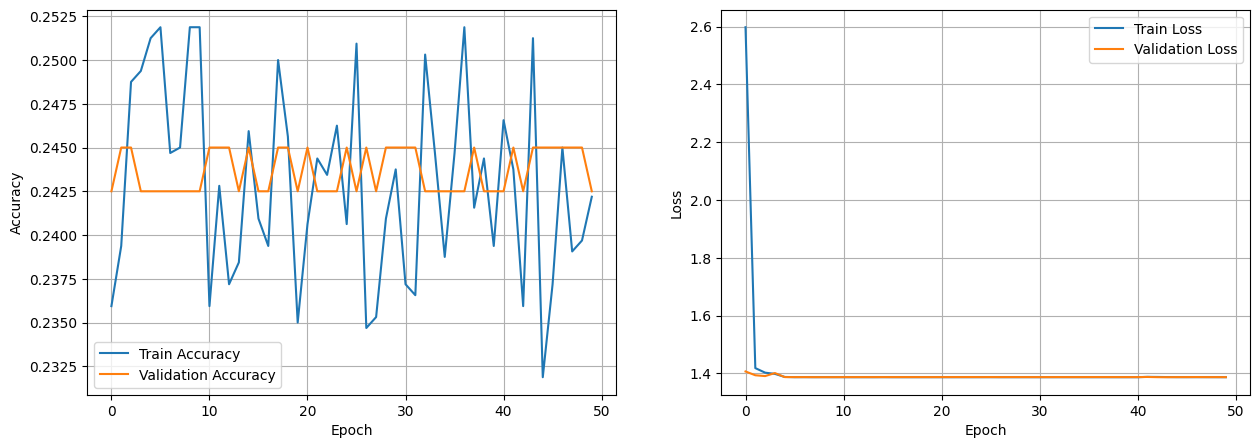

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()